<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/vopo/Volume_of_tumor_PKG_UPENN_GBM_NIfTI_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is about volume calculation using summarize the voxels which are of size 1X1X1 milimeter we only selected the voxel base on its intensity which are greater than equal to treshold value.

In [ ]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 64.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# neural imaging
import nilearn as nl
import nibabel as nib


In [ ]:
DATASET_PATH = r"/content/drive/MyDrive/PKG - UPENN-GBM NIfTI files/NIfTI-files" +'/'

VOXEL SIZE IN MILIMETER

In [ ]:
import nibabel as nib

# Load the NIfTI image
nifti_file_path = DATASET_PATH + 'images_structural/UPENN-GBM-00001_11/UPENN-GBM-00001_11_FLAIR.nii'
nifti_image = nib.load(nifti_file_path)

# Access the header from the NIfTI image object to get the voxel size
header = nifti_image.header
voxel_size = header.get_zooms()

# The voxel_size variable now contains the voxel size in millimeters for each dimension (X, Y, and Z)
voxel_size_x_mm, voxel_size_y_mm, voxel_size_z_mm = voxel_size

print(f'Voxel size (X): {voxel_size_x_mm} mm')
print(f'Voxel size (Y): {voxel_size_y_mm} mm')
print(f'Voxel size (Z): {voxel_size_z_mm} mm')


Voxel size (X): 1.0 mm
Voxel size (Y): 1.0 mm
Voxel size (Z): 1.0 mm


fetching Ids of images and mask and select those corresponding ids which have mask

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


train_data_ids = [f.path for f in os.scandir(DATASET_PATH + 'images_structural')]

training_data_ids = pathListIntoIds(train_data_ids);

In [ ]:
len(training_data_ids)

671

In [ ]:
mask_data_ids = [f.path for f in os.scandir(DATASET_PATH + 'automated_segm')]

mask_data_ids = pathListIntoIds(mask_data_ids);

In [ ]:
mask_ids = []
for i in range(len(mask_data_ids)):
  test = mask_data_ids[i].split('_automated_approx_segm.nii')[0]
  mask_ids.append(test)

In [ ]:
training_data_ids.sort()
mask_ids.sort()

In [ ]:
len(mask_ids)

611

In [ ]:
len(training_data_ids)

671

In [ ]:
result_ids =[]
for i in mask_ids:
  if i in training_data_ids:
    result_ids.append(i)


In [ ]:
len(result_ids)

611

Normalising function (min max normalisaion)

In [ ]:
def min_max_scaling(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

testing one or two image for volume calculation

In [ ]:
Path = DATASET_PATH + 'images_structural/'
case_path = os.path.join(Path, result_ids[50])
data_path = os.path.join(case_path, f'{result_ids[50]}_FLAIR.nii')
img = nib.load(data_path)
flair = img.get_fdata()
normalized_img =  min_max_scaling(flair)
 # Adjust the threshold value as needed
threshold = .1
thresholded_data = np.where(normalized_img <= threshold, 0, 1)
voxel_size_mm = np.prod(img.header.get_zooms())
voxel_size_cm = voxel_size_mm*0.1
# Calculate the volume in cubic millimeters
volume_mm3 = np.sum(thresholded_data) * voxel_size_cm**3

In [ ]:
np.min(normalized_img), np.max(normalized_img), flair.shape, type(normalized_img)

(0.0, 1.0, (240, 240, 155), numpy.ndarray)

In [ ]:
volume_mm3

1196.8920000000003

In [ ]:
volume_mm3

1446.9520000000005

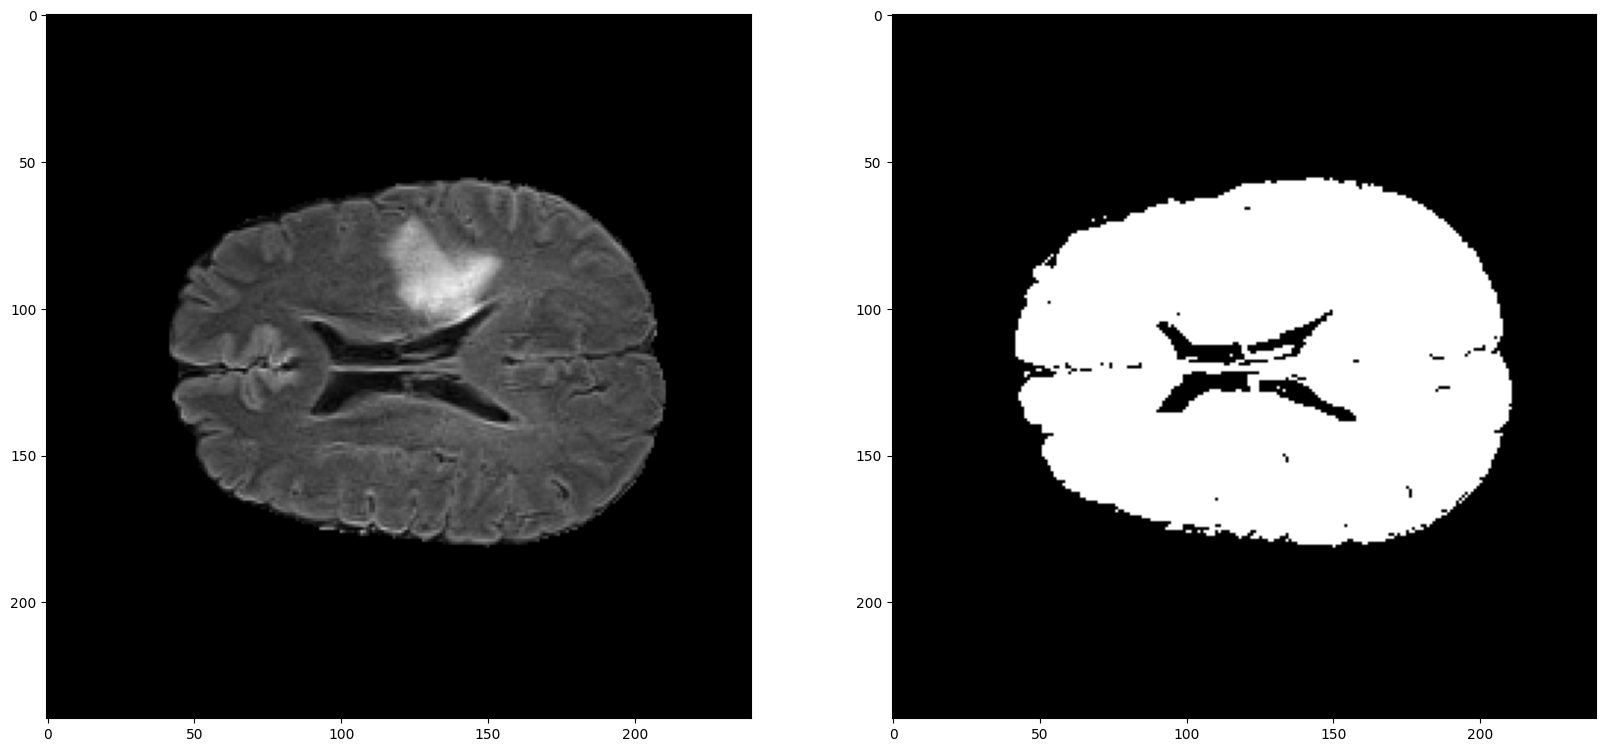

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 10))
slice_w = 35
ax1.imshow(normalized_img[:,:,normalized_img.shape[0]//2-slice_w], cmap = 'gray')
ax2.imshow(thresholded_data[:,:,thresholded_data.shape[0]//2-slice_w], cmap = 'gray')

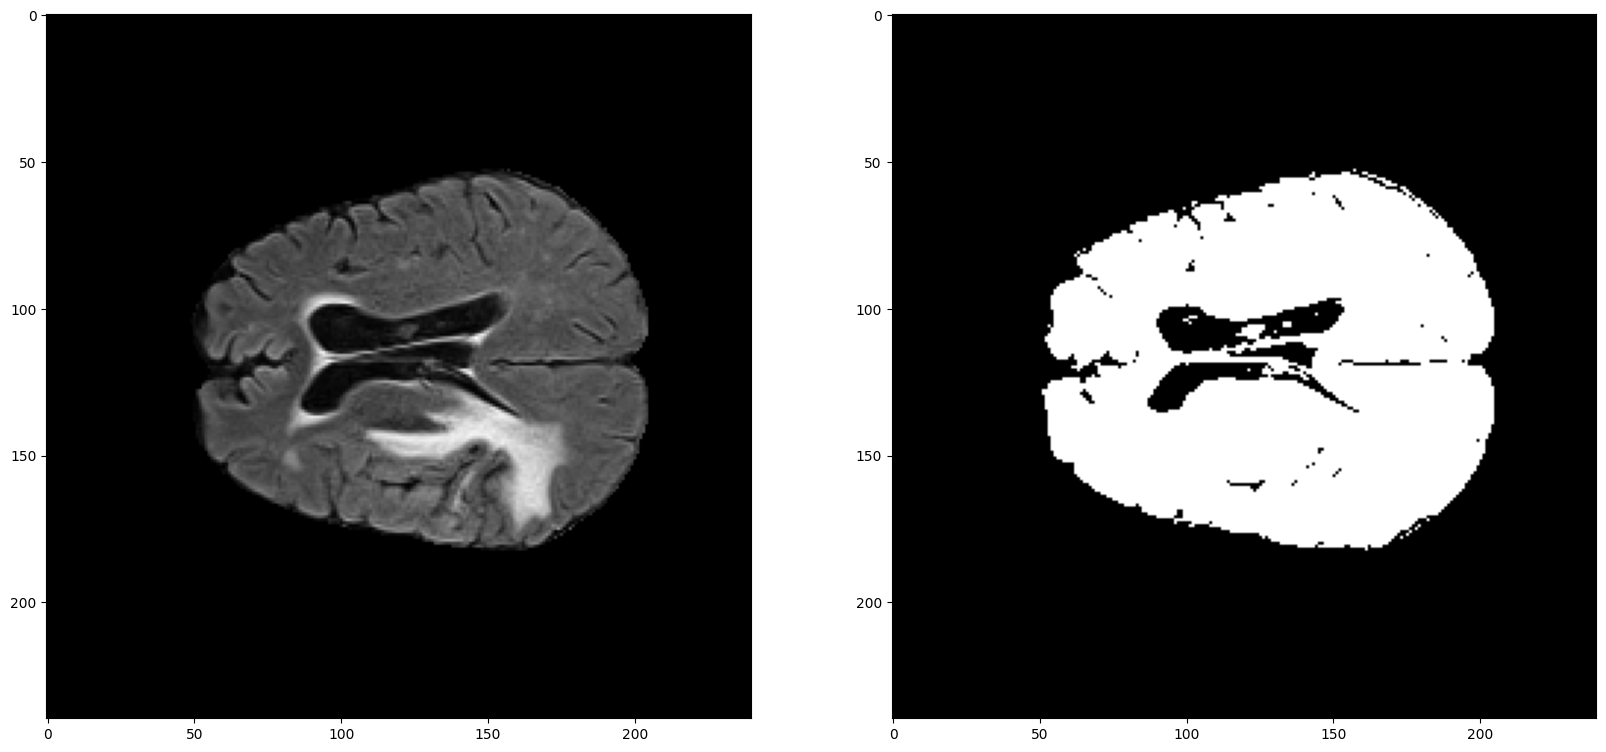

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 10))
slice_w = 30
ax1.imshow(normalized_img[:,:,normalized_img.shape[0]//2-slice_w], cmap = 'gray')
ax2.imshow(thresholded_data[:,:,thresholded_data.shape[0]//2-slice_w], cmap = 'gray')

Volume calcualtion of brain images are done and save it into a list

In [ ]:
volume = []
for i in range(len(result_ids)):
  Path = DATASET_PATH + 'images_structural/'
  case_path = os.path.join(Path, result_ids[i])
  data_path = os.path.join(case_path, f'{result_ids[i]}_FLAIR.nii')
  img = nib.load(data_path)
  flair = img.get_fdata()
  normalized_img =  min_max_scaling(flair)
  threshold_value = 0.1 # Adjust the threshold value as needed
  thresholded_data = np.where(normalized_img <= threshold_value, 0, 1)
# Calculate the voxel size (assuming isotropic voxel dimensions)
  voxel_size_mm = np.prod(img.header.get_zooms())
  voxel_size_cm = voxel_size_mm*0.1
# Calculate the volume in cubic millimeters
  volume_mm3 = np.sum(thresholded_data) * voxel_size_cm**3
  volume.append(volume_mm3)


In [ ]:
volume[0]

1335.8050000000003

In [ ]:
volume[0]

1417.4330000000004

In [ ]:
len(volume)

611

volume of tumor is also calculated here and save it into a list

In [ ]:
volume_t = []
for i in range(len(result_ids)):
  case_path = os.path.join(DATASET_PATH,'automated_segm')
  data_path = os.path.join(case_path, f'{result_ids[i]}_automated_approx_segm.nii')
  img = nib.load(data_path)
  flair = img.get_fdata()
  threshold_value = 0.0  # Adjust the threshold value as needed
  thresholded_data = np.where(flair > threshold_value, 1, 0)
# Calculate the voxel size (assuming isotropic voxel dimensions)
  voxel_size_mm = np.prod(img.header.get_zooms())
  voxel_size_cm = voxel_size_mm*0.1
# Calculate the volume in cubic millimeters
  volume_mm3 = np.sum(thresholded_data) * voxel_size_cm**3
  volume_t.append(volume_mm3)


In [ ]:
len(volume_t)

611

Percentage of tumor with repect to brain volume is calculated

In [ ]:
# List to store the calculated percentages
percentages = []

# Calculate percentages and append them to the 'percentages' list
for part, whole in zip(volume_t, volume):
    # Calculate the percentage
    percentage = (part / whole) * 100
    rounded_percentage = round(percentage, 2)
    # Append the result to the 'percentages' list
    percentages.append(rounded_percentage)

# Display the list of percentages
print("Percentages:", percentages)



Percentages: [1.73, 14.36, 4.48, 4.14, 6.25, 4.47, 7.1, 2.33, 7.83, 2.19, 6.68, 7.86, 1.38, 9.04, 6.42, 3.06, 2.57, 13.86, 4.2, 1.95, 3.54, 12.69, 8.12, 3.67, 3.08, 3.59, 4.13, 7.88, 11.92, 1.91, 3.98, 10.0, 3.0, 2.84, 8.46, 11.14, 4.35, 11.05, 7.35, 4.92, 8.39, 6.19, 8.02, 15.87, 5.74, 7.41, 1.01, 10.78, 2.84, 0.87, 2.42, 8.98, 14.31, 12.02, 4.46, 8.68, 6.8, 7.61, 9.17, 6.89, 3.35, 4.18, 12.89, 6.56, 14.07, 4.19, 3.77, 12.49, 8.24, 1.27, 10.77, 6.64, 3.18, 3.81, 2.44, 11.13, 11.32, 4.37, 11.22, 3.17, 3.43, 4.59, 3.3, 14.62, 4.32, 10.33, 2.62, 6.84, 12.66, 2.76, 4.36, 3.62, 6.77, 8.99, 6.09, 6.66, 2.35, 3.76, 8.34, 12.94, 6.68, 1.44, 5.46, 10.49, 5.23, 0.87, 7.04, 5.59, 9.94, 10.01, 12.35, 2.26, 10.23, 7.36, 1.23, 3.18, 13.59, 8.7, 4.81, 9.57, 10.68, 7.37, 5.18, 6.27, 6.63, 7.42, 4.88, 6.17, 10.45, 10.66, 3.33, 4.49, 1.33, 2.24, 1.21, 8.0, 1.57, 7.01, 8.23, 1.45, 5.63, 7.73, 6.04, 10.01, 6.97, 1.48, 3.92, 8.62, 6.16, 1.61, 7.68, 12.36, 2.28, 4.34, 9.1, 7.74, 8.23, 6.05, 5.55, 2.88, 0.5

Saved all the list into a dataframe and further save it as a csv file

In [ ]:
df = pd.DataFrame(volume,columns =['brain_volume_in_cm^3'])

df

,brain_volume_in_cm^3
0,1335.805
1,1397.175
2,1510.118
3,1353.416
4,1423.718
...,...
606,1186.778
607,1098.056
608,1389.376
609,1392.195


In [ ]:
df['brain_tumor_volume_in_cm^3'] = volume_t
df['brain_tumor_%'] = percentages

df

,brain_volume_in_cm^3,brain_tumor_volume_in_cm^3,brain_tumor_%
0,1335.805,23.160,1.73
1,1397.175,200.670,14.36
2,1510.118,67.650,4.48
3,1353.416,56.097,4.14
4,1423.718,89.027,6.25
...,...,...,...
606,1186.778,147.051,12.39
607,1098.056,116.132,10.58
608,1389.376,85.827,6.18
609,1392.195,6.180,0.44


In [ ]:
df.to_csv('UPENN-GBM NIfTI files_vol_of_brain_tumor_new.csv')

In [ ]:
def remove_unmatch_ids(dataset1,dataset2):
  for i in dataset1:
    if i not in dataset2:
      dataset1.remove(i)